In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import warnings
import numpy as np
import cv2
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
background = None
accumulated_weight = 0.5

#Creating the dimensions for the ROI...

ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350
def cal_accum_avg(frame, accumulated_weight):
    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None
    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [3]:
def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)
    _ , thresholded = cv2.threshold(diff, threshold,255,cv2.THRESH_BINARY)
    
    # Grab the external contours for the image
    contours, hierarchy = cv2.findContours(thresholded.copy(),
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    else:
        
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        return (thresholded, hand_segment_max_cont)

In [62]:
cam = cv2.VideoCapture(0)

num_frames = 0
element = '9'
num_imgs_taken = 0

while True:
    ret, frame = cam.read()

    # flipping the frame to prevent inverted image of captured frame...
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

    if num_frames < 60:
        cal_accum_avg(gray_frame, accumulated_weight)
        if num_frames <= 59:
            
            cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT",
(80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
            
    elif num_frames <= 300: 

        hand = segment_hand(gray_frame)
        
        cv2.putText(frame_copy, "Adjust hand...Gesture for" +
  str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1,
  (0,0,255),2)
        
        if hand is not None:
            
            thresholded, hand_segment = hand

            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
            ROI_top)], -1, (255, 0, 0),1)

            cv2.putText(frame_copy, str(num_frames)+"For" + element,
            (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

            # Also display the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
    
    else: 
        
        # Segmenting the hand region...
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            # unpack the thresholded img and the max_contour...
            thresholded, hand_segment = hand

            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
            ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames), (70, 45),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            cv2.putText(frame_copy, str(num_imgs_taken) + 'images' +"For"
      + element, (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1,
      (0,0,255), 2)
            
            # Displaying the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
            if num_imgs_taken <= 1000:
                cv2.imwrite(r"D:\\gesture\\train\\"+ element +"\\" +
                str(num_imgs_taken+300) + '.jpg', thresholded)
                
            else:
                break
            num_imgs_taken +=1
        else:
            cv2.putText(frame_copy, 'No hand detected...', (200, 400),
 cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)




    # Drawing ROI on frame copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,128,0), 3)
    
    cv2.putText(frame_copy, "Hand sign recognition_ _ _", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    
    # increment the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    cv2.imshow("Sign Detection", frame_copy)

    # Closing windows with Esc key...(any other key with ord can be used too.)
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

# Releasing the camera & destroying all the windows...

cv2.destroyAllWindows()
cam.release()

In [37]:
#Creating Test Set

cam = cv2.VideoCapture(0)

num_frames = 0
element = 10
num_imgs_taken = 0

while True:
    ret, frame = cam.read()

    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

    if num_frames < 60:
        cal_accum_avg(gray_frame, accumulated_weight)
        if num_frames <= 59:
            
            cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT",
(80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
            
    elif num_frames <= 300: 

        hand = segment_hand(gray_frame)
        
        cv2.putText(frame_copy, "Adjust hand...Gesture for" +
  str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1,
  (0,0,255),2)
        
        if hand is not None:
            
            thresholded, hand_segment = hand

            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
            ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames)+"For" + str(element),
            (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

            cv2.imshow("Thresholded Hand Image", thresholded)
    
    else: 
        
        hand = segment_hand(gray_frame)
        
        if hand is not None:
            
            thresholded, hand_segment = hand

            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
            ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames), (70, 45),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            cv2.putText(frame_copy, str(num_imgs_taken) + 'images' +"For"
      + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1,
      (0,0,255), 2)
            
            cv2.imshow("Thresholded Hand Image", thresholded)
            if num_imgs_taken <= 50:
                cv2.imwrite(r"D:\\gesture\\test\\"+str(element)+"\\" +
                str(num_imgs_taken+300) + '.jpg', thresholded)
                
            else:
                break
            num_imgs_taken +=1
        else:
            cv2.putText(frame_copy, 'No hand detected...', (200, 400),
 cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)




    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,128,0), 3)
    
    cv2.putText(frame_copy, "Hand sign recognition_ _ _", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    
    num_frames += 1

    cv2.imshow("Sign Detection", frame_copy)

    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break


cv2.destroyAllWindows()
cam.release()

In [63]:
train_path = r'D:\gesture\train'
test_path = r'D:\gesture\test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(64,64), class_mode='categorical', batch_size=10,shuffle=True)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)

Found 33033 images belonging to 33 classes.
Found 1653 images belonging to 33 classes.


In [64]:
import matplotlib
from matplotlib import pyplot as plt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

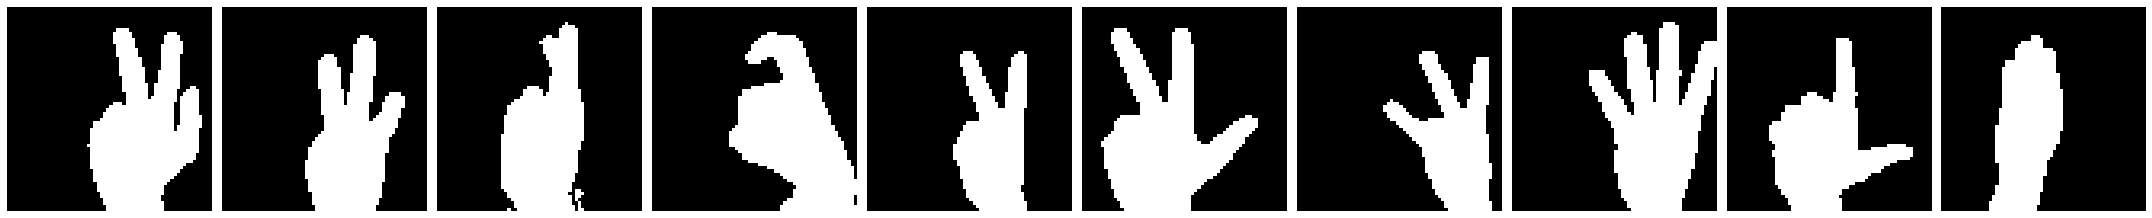

(10, 64, 64, 3)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0

In [65]:
imgs, labels = next(train_batches)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(imgs)
print(imgs.shape)
print(labels)

In [80]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
model.add(Dropout(0.3))
model.add(Dense(33,activation ="softmax"))

In [81]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 128)       

In [82]:
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [83]:
history2 = model.fit(train_batches, epochs=7, callbacks=[reduce_lr, early_stop],  validation_data = test_batches)

Epoch 1/7
3304/3304 [==============================] - 975s 295ms/step - loss: 3.1770 - accuracy: 0.1205 - val_loss: 2.3439 - val_accuracy: 0.2365 - lr: 0.0010
Epoch 2/7
3304/3304 [==============================] - 386s 117ms/step - loss: 1.6649 - accuracy: 0.4730 - val_loss: 0.3733 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 3/7
3304/3304 [==============================] - 261s 79ms/step - loss: 0.4354 - accuracy: 0.8548 - val_loss: 0.0640 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 4/7
3304/3304 [==============================] - 488s 148ms/step - loss: 0.1616 - accuracy: 0.9472 - val_loss: 0.0157 - val_accuracy: 0.9958 - lr: 0.0010
Epoch 5/7
3304/3304 [==============================] - 175s 53ms/step - loss: 0.0906 - accuracy: 0.9708 - val_loss: 0.0121 - val_accuracy: 0.9970 - lr: 0.0010
Epoch 6/7
3304/3304 [==============================] - 174s 53ms/step - loss: 0.0557 - accuracy: 0.9821 - val_loss: 0.0011 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/7
3304/3304 [======================

In [97]:
imgs, labels = next(test_batches) 

scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


loss of 0.023793155327439308; accuracy of 100.0%


In [108]:
#Once the model is fitted we save the model using model.save()  function.
from keras.models import load_model

model.save("new_model.h5")

In [109]:
from keras.models import load_model

model_path1 =r"C:\Users\hp\Downloads\whatsapp harry\new_model.h5"
model = load_model(model_path1)

predictions on a small set of test data--

F   Nine   Seven   E   V   Nine   Q   E   H   Eight   

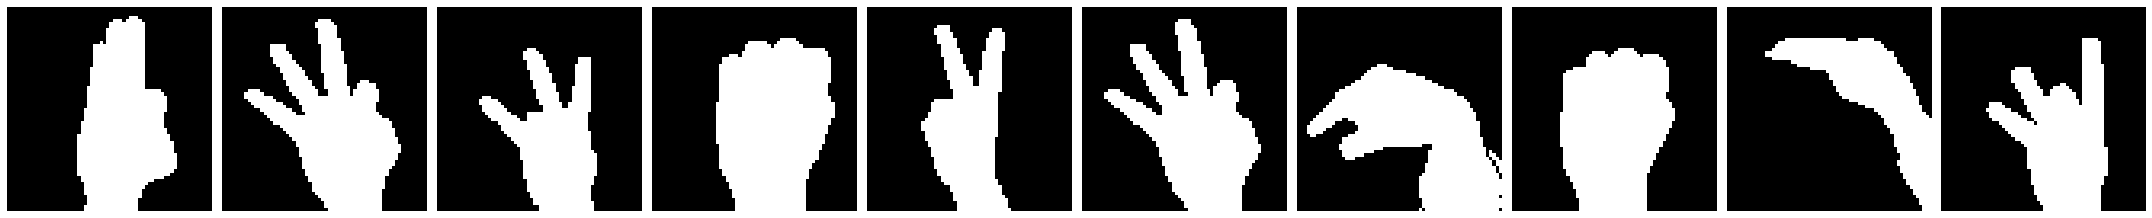

Actual labels
F   Nine   Seven   E   V   Nine   Q   E   H   Eight   

In [112]:
#word_dict = {0:'One',1:'Ten',2:'Two',3:'Three',4:'Four',5:'Five',6:'Six',7:'Seven',8:'Eight',9:'Nine'}

word_dict = {0: 'One', 1: 'Two', 2: 'Three', 3: 'Four', 4: 'Five', 5: 'Six', 6: 'Seven', 7: 'Eight',
               8: 'Nine', 9: 'A', 10: 'B', 11: 'C', 12: 'D', 13: 'E',
               14: 'F', 15: 'G', 16: 'H', 17: 'I', 18: 'K', 19: 'L', 20: 'M',
               21: 'N', 22: 'O', 23: 'P', 24: 'Q', 25: 'R', 26: 'S',
               27: 'T', 28: 'U', 29: 'V', 30: 'W', 31: 'X', 32: 'Y'}

predictions = model.predict(imgs, verbose=0)
print("predictions on a small set of test data--")
print("")
for ind, i in enumerate(predictions):
    print(word_dict[np.argmax(i)], end='   ')

plotImages(imgs)
print('Actual labels')
for i in labels:
    print(word_dict[np.argmax(i)], end='   ')


In [113]:
import numpy as np
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [114]:
background = None
accumulated_weight = 0.5

ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350

In [115]:
def cal_accum_avg(frame, accumulated_weight):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None

    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [116]:
def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)

    
    _ , thresholded = cv2.threshold(diff, threshold, 255,
    cv2.THRESH_BINARY)
    

    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None
    else:
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        return (thresholded, hand_segment_max_cont)

In [118]:
cam = cv2.VideoCapture(0)
num_frames =0
while True:
    ret, frame = cam.read()

    
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    # ROI from the frame
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)


    if num_frames < 70:
        
        cal_accum_avg(gray_frame, accumulated_weight)
        
        cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT",
  (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
    
    else: 
        hand = segment_hand(gray_frame)
        
        if hand is not None:
            
            thresholded, hand_segment = hand

            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
      ROI_top)], -1, (255, 0, 0),1)
            
            cv2.imshow("Thesholded Hand Image", thresholded)
            
            thresholded = cv2.resize(thresholded, (64, 64))
            thresholded = cv2.cvtColor(thresholded,
 cv2.COLOR_GRAY2RGB)
            thresholded = np.reshape(thresholded,
(1,thresholded.shape[0],thresholded.shape[1],3))
            
            pred = model.predict(thresholded)
            cv2.putText(frame_copy, word_dict[np.argmax(pred)],
(170, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,
    ROI_bottom), (255,128,0), 3)

    num_frames += 1

    cv2.putText(frame_copy, "Hand sign recognition_ _ _",
    (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    cv2.imshow("Sign Detection", frame_copy)

    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

cam.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 37ms/step
